# **Serie multivariada**

## <span style="color:blue">Importar las librería requeridas</span>

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

print('version de tf: ', tf.__version__)

from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 

version de tf:  2.5.0


## <span style="color:blue">Datos - AAPL </span> 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UN_Mineria_de_datos/Proyecto/Archivos/Datos_Sentimiento/AAPL_fin_2.csv', sep=';', header=0)

### Una primera mirada a los datos 

In [4]:
df.head()

,post_date,numero,retweets,likes,positivo,negativo,dif_close,Indicadora,dif_std,Indicadora_2,retweetXcal
0,2015-01-02,867,2.115340,0.504037,0.239908,0.517878,-0.770000,0,-0.060877,0,0.342421
1,2015-01-05,1145,0.360699,0.517031,0.248035,0.449782,0.002501,0,0.168522,0,0.024213
2,2015-01-06,1190,0.190756,0.393277,0.288235,0.389916,0.372499,0,0.278396,0,-0.308370
3,2015-01-07,1087,0.191352,0.507820,0.261270,0.433303,1.035000,1,0.475129,1,-0.091346
4,2015-01-08,1491,0.334004,0.570758,0.335345,0.396378,0.030001,0,0.176689,0,0.038153


In [5]:
df.describe().T 

,count,mean,std,min,25%,50%,75%,max
numero,1253.0,977.901836,603.766954,7.000000,622.000000,826.000000,1158.000000,5029.000000
retweets,1253.0,0.504838,0.318086,0.000000,0.314759,0.418902,0.588872,2.671982
likes,1253.0,1.044028,0.711237,0.142857,0.495690,0.878492,1.407643,5.200346
positivo,1253.0,0.251788,0.046768,0.000000,0.220725,0.249673,0.278632,0.571429
negativo,1253.0,0.539958,0.064412,0.166667,0.498503,0.538131,0.577812,1.000000
dif_close,1253.0,0.037829,0.621583,-3.932499,-0.212500,0.027496,0.334999,2.802502
Indicadora,1253.0,-0.003192,0.324686,-1.000000,0.000000,0.000000,0.000000,1.000000
dif_std,1253.0,0.179013,0.184583,-1.000000,0.104677,0.175945,0.267260,1.000000
Indicadora_2,1253.0,0.105347,0.307123,0.000000,0.000000,0.000000,0.000000,1.000000
retweetXcal,1252.0,-0.202271,0.266870,-0.923077,-0.369054,-0.213224,-0.050821,0.911513


In [6]:
df.dtypes

post_date        object
numero            int64
retweets        float64
likes           float64
positivo        float64
negativo        float64
dif_close       float64
Indicadora        int64
dif_std         float64
Indicadora_2      int64
retweetXcal     float64
dtype: object

In [7]:
df['indi_bin']=df['Indicadora'].abs()

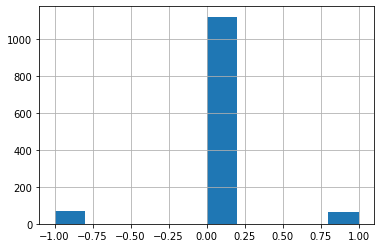

In [8]:
df['Indicadora'].hist()

(array([-50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38,
        -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25,
        -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12,
        -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
          2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50]),
 array([0.70796304, 0.70504358, 0.70028399, 0.69686629, 0.70902719,
        0.70557382, 0.70124403, 0.71944694, 0.70819079, 0.70725596,
        0.71206026, 0.73048356, 0.72636233, 0.71381092, 0.71487965,
        0.74041178, 0.71493998, 0.71008082, 0.71193665, 0.72782205,
        0.73494338, 0.71671867, 0.72163031, 0.71877361, 0.75288026,
        0.73444131, 0.74170142, 0.73879401, 0.74987975, 0.73489902,
        0.73031311, 0

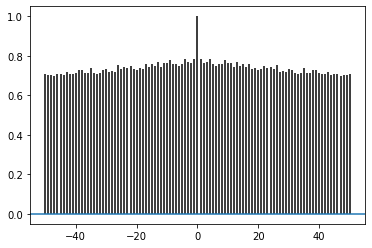

In [9]:
# Plotting the Autocorrelation plot.
plt.acorr(df['retweets'], maxlags = 50)

[]

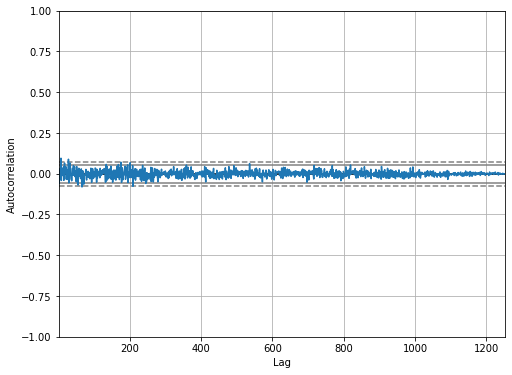

In [ ]:
# Creating Autocorrelation plot
x = pd.plotting.autocorrelation_plot(df['dif_close'])
  
# ploting the Curve
x.plot()

Como puede verse arriba, se registra una observación cada 10 minutos. Esto significa que, durante una hora, se tendrán 6 observaciones. Del mismo modo, en un  día se tienen 144 (6x24) observaciones. En total son 420551 observaciones.

Dado un tiempo específico, digamos que desea predecir la temperatura 6 horas en el futuro. Para hacer esta predicción, se elige usar 5 días de observaciones. Por lo tanto, crearía una ventana que contiene las últimas 720 (5x144) observaciones para entrenar el modelo. Son posibles muchas de estas configuraciones, lo que hace que este conjunto de datos sea bueno para experimentar.

La siguiente función devuelve las ventanas de tiempo descritas anteriormente para entrenar el modelo. El parámetro *history_size* es el tamaño de la ventana de información pasada. El *target_size* es qué tan lejos en el futuro necesita el modelo aprender a predecir; *target_size* es la etiqueta que debe predecirse.

## <span style="color:blue">Funciones para gráficos</span>

In [10]:
def create_time_steps(length):
  return list(range(-length, 0))

In [11]:
def show_plot(plot_data, delta, title):
  labels = ['Historia', 'Futuro Verdadero' , 'Predicción del Modelo']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Salto de tiempo (Time-Step)')
  return plt

In [12]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Pérdida entrenamiento')
    plt.plot(epochs, val_loss, 'r', label='Pérdida validación')
    plt.title(title)
    plt.legend()

    plt.show()

In [13]:
def plot_serie_prediction(y_test, y_pred,rms, epochs):
    plt.plot(np.arange(0, len(y_test)), y_test, marker='.', label="verdadero")
    plt.plot(np.arange(0, len(y_test)), y_pred, marker='+', label="predicho")
    plt.xlabel('Time Step')
    plt.annotate("rms = "+str(round(rms,2)) , xy=(100, 140), size = 15)
    #plt.annotate("modelo = LSTM(50), timestep=60" , xy=(100, 146), size = 15)
    #plt.annotate("epochs=40" , xy=(100, 143), size = 15)
    plt.title("Intervalo de predicción a un día. Escala original", size = 20)
    plt.legend()
    plt.show()

## <span style="color:blue">Funciones para preparar datos de entrenamiento</span>

### Caso Univariado

In [14]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    ''' dataset: conjunto de datos
        start_index: índice inicial de donde empezar a tomar los datos
        end_index: índice final para tomar los datos. None para tomarlos todos
        history_size: tamaño de la venytana para crear las secuencias
        target_size: dentro de cuántas observaciones futuras desea pronosticar
    '''
   
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    
    return np.array(data), np.array(labels)

### Caso multivariado

In [15]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    ''' dataset: conjunto de datos para las secuencias de entrada
        target:  conjunto de datos para las secuencias de salida
        start_index: índice inicial de donde empezar a tomar los datos
        end_index: índice final para tomar los datos. None para tomarlos todos
        history_size: tamaño de la venytana para crear las secuencias
        target_size: dentro de cuántas observaciones futuras desea pronosticar
        step: Cada cuántas observaciones deben tomarse. Para secuencias muy largas
              que no cambia mucho localmente
        single_step: Predecir solamente un valor futuro (=True),
                     o predecir todos los valores hasta target_size(=False)
    '''  
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

En las partes  siguientes, las primeras 300,000 filas de datos serán el conjunto de datos de entrenamiento, y el resto será el conjunto de datos de validación (120551). Esto equivale a unos 2100 días de datos de entrenamiento.


## <span style="color:blue">Pronóstico de una serie de tiempo multivariada</span>


El conjunto de datos original contiene catorce variables (features). Para simplificar, esta sección considera solo tres de los catorce originales. Las características utilizadas son la temperatura del aire, la presión atmosférica y la densidad del aire.

Para usar más variables, agregue sus nombres a esta lista.

In [ ]:
print(df.shape[0])
df.shape[0]*0.25

1253


313.25

In [22]:
TRAIN_SPLIT = 1250

Se coloca una semilla para gerantizar reproductibidad

In [16]:
tf.random.set_seed(13)

In [17]:
features_considered = ['numero', 'retweets', 'likes', 'positivo']#, 'negativo'

In [18]:
features = df[features_considered]
features.index = df['post_date']
features.head()

,numero,retweets,likes,positivo
post_date,,,,
2015-01-02,867,2.115340,0.504037,0.239908
2015-01-05,1145,0.360699,0.517031,0.248035
2015-01-06,1190,0.190756,0.393277,0.288235
2015-01-07,1087,0.191352,0.507820,0.261270
2015-01-08,1491,0.334004,0.570758,0.335345



Echemos un vistazo a cómo cada una de estas características varía con el tiempo.


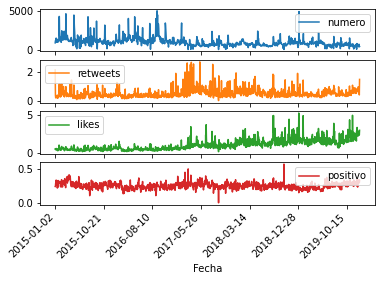

In [19]:
features.plot(subplots=True, rot=45, xlabel='Fecha')
plt.show()

Como se mencionó, el primer paso será estandarizar el conjunto de datos utilizando la media y la desviación estándar de los datos de entrenamiento.

In [23]:
#fecha = features_date['post_date'].values
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [24]:
dataset = (dataset-data_mean)/data_std

In [52]:
 dataset[0,0:4]

array([-0.18563351,  5.08031896, -0.75811692, -0.25094164])

In [32]:
#df_indi=df[['Indicadora']].reset_index()
from tensorflow.keras.utils import to_categorical
df['Indicadora'][df['Indicadora']==-1]=2
df_indi= pd.DataFrame(to_categorical(df.Indicadora))
df_indi#.columns = target_dimensions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,0,1,2
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
...,...,...,...
1248,1.0,0.0,0.0
1249,0.0,1.0,0.0
1250,1.0,0.0,0.0
1251,1.0,0.0,0.0


In [33]:
dataset=np.array(np.concatenate( (dataset,df_indi),axis = 1),dtype='float')
#features_date.iloc[:,1:6].values
#dataset
#features_date

In [43]:
# Cuenta las frecuencias de los datos
counts = df_indi.sum(axis=0)
print(counts)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(df_indi.iloc[:,1])
    )
)

# Crea los pesos para el entrenamiento. Más peso a los menos frecuentes (1)
weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]
weight_for_2 = 1.0 / counts[2]

0    1121.0
1      64.0
2      68.0
dtype: float32
Number of positive samples in training data: 64.0 (5.11% of total)


In [45]:
print(weight_for_0)
print(weight_for_1)
print(weight_for_2)

0.0008920606601248885
0.015625
0.014705882352941176


## <span style="color:blue">Modelo de un Paso</span>


En una configuración de un  paso, el modelo aprende a predecir un solo punto en el futuro en función del historial proporcionado.

La función a continuación realiza la misma tarea de ventanas que antes, sin embargo, aquí muestra la observación pasada en función del tamaño de paso dado.

### Crea arreglos de datos de entrenamiento y validación

In [53]:
past_history = 7
future_target = 1
STEP = 1
target = 4

x_train_single, y_train_single = multivariate_data(dataset[:,0:4], dataset[:, 4:7], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
TRAIN_SPLIT2 = 950
x_val_single, y_val_single = multivariate_data(dataset[:,0:4], dataset[:, 4:7],
                                               TRAIN_SPLIT2, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [54]:
print(dataset.shape)
print(x_train_single.shape)
print(y_train_single.shape)
print(x_val_single.shape)
print(y_val_single.shape)

(1253, 7)
(1243, 7, 4)
(1243, 3)
(295, 7, 4)
(295, 3)


Veamos una ventana de datos de la historia pasada

In [ ]:
print ('Ventana ejemplo de la historia pasada : {}'.format(x_train_single[0].shape))

In [55]:
y_train_single[0:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

### Crea objetos tf.data.Dataset para entreno y validación

Para manejo más eficiente de memoria 

In [56]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

### Modelo LSTM 

In [65]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D,Activation
from tensorflow.keras.layers import Embedding
from sklearn.metrics import confusion_matrix

In [146]:
input_shape = (x_train_single.shape[1], x_train_single.shape[2])
units = 64
drop_out_rate = 0.01

# layers
inputs = Input(input_shape)
x = Dropout(drop_out_rate/2, name= 'Dropout_01')(inputs)
x = LSTM(units=units, name='LSTM_layer',
         dropout=drop_out_rate/2, recurrent_dropout=0.2, activation='relu',return_sequences =True)(x)        # 
#x = Dropout(drop_out_rate/4, name= 'Dropout_02')(x)
#x = LSTM(units=units//2, name='LSTM_layer2',
#         dropout=drop_out_rate/4, recurrent_dropout=0.2, activation='tanh',return_sequences =True)(x)
x = Dropout(drop_out_rate/6, name= 'Dropout_03')(x)         
x = LSTM(units=units//4, name='LSTM_layer3',
         dropout=drop_out_rate/6, recurrent_dropout=0.1, activation='relu')(x)     #      
x = Dense(1, activation='softmax')(x)
outputs = Dense(3)(x)

#x = Activation('relu')(inputs)
#x = Dense(units, activation='relu',name='primera_capa_oculta')(x)
#x = Dense(units, activation='relu', name='segunda_capa_oculta')(x)
#outputs = Dense(3, activation='softmax', name='capa_salida')(x)

# model
single_step_model = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
single_step_model.summary()


#single_step_model = tf.keras.models.Sequential()
#single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
#single_step_model.add(tf.keras.layers.Dense(1))

Model: "series_LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 7, 4)]            0         
_________________________________________________________________
Dropout_01 (Dropout)         (None, 7, 4)              0         
_________________________________________________________________
LSTM_layer (LSTM)            (None, 7, 64)             17664     
_________________________________________________________________
Dropout_03 (Dropout)         (None, 7, 64)             0         
_________________________________________________________________
LSTM_layer3 (LSTM)           (None, 16)                5184      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 17        
_________________________________________________________________
dense_33 (Dense)             (None, 3)           

### Compila

In [147]:
single_step_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

Revisemos una predicción simple

In [120]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(64, 3)


In [121]:
#single_step_model.predict(x).T
?single_step_model.fit

In [122]:
counts

0    1121.0
1      64.0
2      68.0
dtype: float32

### Entrena

In [148]:
EVALUATION_INTERVAL = 200
EPOCHS = 20
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=10,shuffle=True,class_weight=class_weight) #

Epoch 1/20
200/200 [==============================] - 10s 23ms/step - loss: 0.0128 - accuracy: 0.0547 - val_loss: 1.9123 - val_accuracy: 0.1153
Epoch 2/20
200/200 [==============================] - 4s 21ms/step - loss: 0.0128 - accuracy: 0.0547 - val_loss: 1.9123 - val_accuracy: 0.1153
Epoch 3/20
200/200 [==============================] - 4s 21ms/step - loss: 0.0128 - accuracy: 0.0547 - val_loss: 1.9123 - val_accuracy: 0.1153
Epoch 4/20
200/200 [==============================] - 4s 21ms/step - loss: 0.0128 - accuracy: 0.0547 - val_loss: 1.9123 - val_accuracy: 0.1153
Epoch 5/20
200/200 [==============================] - 4s 21ms/step - loss: 0.0128 - accuracy: 0.0547 - val_loss: 1.9123 - val_accuracy: 0.1153
Epoch 6/20
200/200 [==============================] - 4s 20ms/step - loss: 0.0128 - accuracy: 0.0547 - val_loss: 1.9123 - val_accuracy: 0.1153
Epoch 7/20
200/200 [==============================] - 4s 20ms/step - loss: 0.0128 - accuracy: 0.0547 - val_loss: 1.9123 - val_accuracy: 0.115

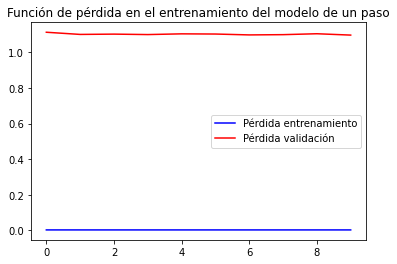

In [127]:
plot_train_history(single_step_history,
                   'Función de pérdida en el entrenamiento del modelo de un paso')

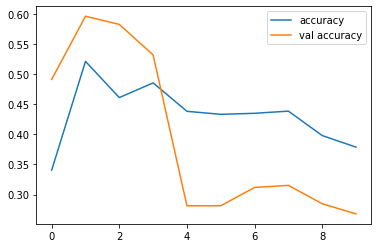

In [117]:
from matplotlib import pyplot as plt

plt.plot(single_step_history.history['accuracy'], label='accuracy')
plt.plot(single_step_history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

## <span style="color:blue">Predicciones</span>


Ahora que el modelo está entrenado, hagamos algunas predicciones de muestra. El modelo tiene el historial de tres features en los últimos cinco días muestreados cada hora (120 puntos de datos), ya que el objetivo es predecir la temperatura, el gráfico solo muestra la temperatura pasada. La predicción se hace un día en el futuro (de ahí la brecha entre la historia y la predicción).

In [108]:
y_val_single[0:5]

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [128]:
# Predicting the Test set results
y_pred = single_step_model.predict(x_val_single)
y_pred_c = np.argmax(y_pred, axis=1)

In [129]:
y_test = np.argmax(y_val_single, axis=1)

In [130]:
print(y_pred.shape)
print(y_test.shape)

(295, 3)
(295,)


In [131]:
cm = confusion_matrix(y_test, y_pred_c)
cm

array([[  0, 226,   0],
       [  0,  35,   0],
       [  0,  34,   0]])

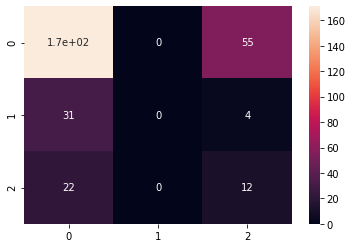

In [101]:
import seaborn as sns
sns.heatmap(cm,annot=True)

In [ ]:
single_step_model.save('/content/drive/MyDrive/Colab Notebooks/UN_Mineria_de_datos/Proyecto/Archivos/Datos_Sentimiento/modelo_2.h5')

In [ ]:
keras.experimental.export_saved_model(single_step_model,'/content/drive/MyDrive/Colab Notebooks/UN_Mineria_de_datos/Proyecto/Archivos/Datos_Sentimiento')

NameError: ignored

### rms

In [ ]:
#rmsLSTM = np.sqrt(np.mean(np.power(y_pred-y_test,2)))
#print(rmsLSTM )

0.5169201850699908


In [ ]:
def plot_series(y_test,y_pred, title, x_label, y_label,epochs):
    plt.plot(np.arange(0, len(y_test)), y_test, marker='.', label="verdadero")
    plt.plot(np.arange(0, len(y_test)), y_pred, marker='+', label="predicho")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    #plt.annotate("rms="+str(round(rms,2)) , xy=(500, 1.3), size = 10)
    #plt.annotate("modelo = LSTM(50), timestep=60" , xy=(100, 146), size = 15)
    #
    plt.annotate("epochs="+str(epochs) , xy=(500, 1.5), size = 10)
    plt.title(title)
    plt.legend()
    plt.show()
    


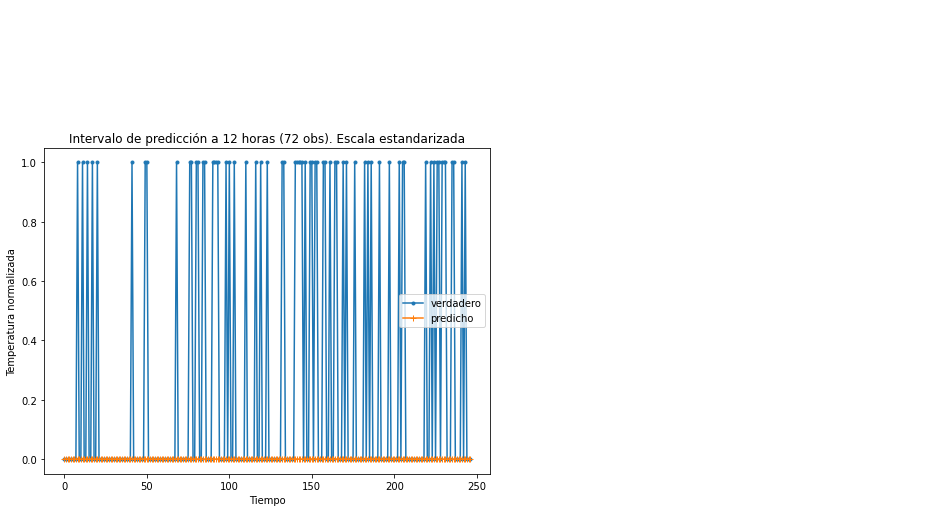

In [ ]:
title = "Intervalo de predicción a 12 horas (72 obs). Escala estandarizada"
x_label = 'Tiempo'
y_label = 'Temperatura normalizada'
rms = rmsLSTM
plot_series(y_test[:2000], y_pred[:2000],title,x_label, y_label, epochs=10 )